In [771]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
import seaborn as sns
sns.set(style="darkgrid")

In [772]:
# 一些全局变量 
is_need_log = False

In [773]:
sales_data = pd.read_csv("./示例数据/order_train2.csv")
test  = pd.read_csv("./示例数据/predict_sku1.csv")

In [774]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/1,104,22069,307,403,offline,1114.0,19
1,2015/9/1,104,20028,301,405,offline,1012.0,12
2,2015/9/2,105,21183,307,403,online,428.0,109
3,2015/9/2,105,20448,308,404,online,962.0,3
4,2015/9/2,104,21565,307,403,offline,1400.0,3


In [775]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597694 entries, 0 to 597693
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         597694 non-null  object 
 1   sales_region_code  597694 non-null  int64  
 2   item_code          597694 non-null  int64  
 3   first_cate_code    597694 non-null  int64  
 4   second_cate_code   597694 non-null  int64  
 5   sales_chan_name    597694 non-null  object 
 6   item_price         597694 non-null  float64
 7   ord_qty            597694 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 36.5+ MB


In [776]:
sales_data.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000
mean,102.941766,21008.015983,304.932094,406.457174,1076.241578,91.650505
std,1.544004,590.896347,2.004195,3.107329,1167.511104,199.843336
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20518.000000,303.000000,404.000000,598.000000,10.000000
50%,103.000000,20976.000000,306.000000,407.000000,883.000000,29.000000
75%,105.000000,21521.000000,306.000000,408.000000,1291.000000,101.000000
max,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000


# 1. Data cleaning

## Remove outliers

<AxesSubplot: xlabel='item_price'>

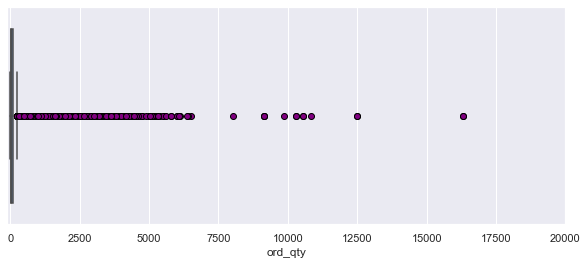

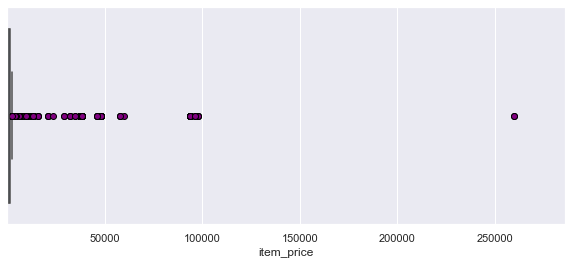

In [777]:
# 销售量
plt.figure(figsize=(10,4))
plt.xlim(-100, 20000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_data.ord_qty, flierprops=flierprops)

# 价格
plt.figure(figsize=(10,4))
plt.xlim(sales_data.item_price.min(), sales_data.item_price.max()*1.1)
sns.boxplot(x=sales_data.item_price, flierprops=flierprops)

In [778]:
sales_data.item_price.max()

260014.0

- 去除销量大于4000的以及价格大于30000的
    - 其实这里还需要验证一下去除的那几条记录，是不是好的，因为可能有些商品就是卖这么多或者怎样
    - 验证一下test集里有没有出现

In [779]:
sales_data = sales_data[(sales_data.item_price < 30000 )& (sales_data.ord_qty < 4000)]

In [780]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/1,104,22069,307,403,offline,1114.0,19
1,2015/9/1,104,20028,301,405,offline,1012.0,12
2,2015/9/2,105,21183,307,403,online,428.0,109
3,2015/9/2,105,20448,308,404,online,962.0,3
4,2015/9/2,104,21565,307,403,offline,1400.0,3


## 数据类型处理

In [781]:
# 时间 object->datetime格式
sales_data["order_date"]=sales_data["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [782]:
# 线上0 线下1
dic = {"offline":1,"online":0}
sales_data['sales_chan_name'] = sales_data['sales_chan_name'].map(dic)

In [783]:
# 单独的item代码，以及其对应的记录条数
train_item = np.unique(sales_data["item_code"],return_counts=True)
train_item

(array([20001, 20002, 20003, ..., 22082, 22083, 22084]),
 array([  13,  694, 2767, ...,  159,  311,  468]))

## 检验这四类code是否一一对应
对后续如何处理很关键

- 简单总结
   - 一级分类和二级分类是一对多的
   - 每个商品只有一个类别，不会对用多种
   - 1421 种商品中，只有 332 种商品是只在一个地区销售的，其他的都在多个地区销售

## 编码label_encoding
- 将地区、item_code、类别进行顺序编码

In [784]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-01,104,22069,307,403,1,1114.0,19
1,2015-09-01,104,20028,301,405,1,1012.0,12
2,2015-09-02,105,21183,307,403,0,428.0,109
3,2015-09-02,105,20448,308,404,0,962.0,3
4,2015-09-02,104,21565,307,403,1,1400.0,3


这里test有train中没有的商品类别（没有更新）
包括
> y contains previously unseen labels: [20011, 20025, 20198, 20273, 20324, 20401, 20449, 20456, 20469, 20503, 20549, 20701, 20721, 20736, 20750, 20793, 20841, 20869, 20951, 20999, 21085, 21184, 21393, 21416, 21523, 21606, 21667, 21687, 21823, 21867, 21879, 21954, 22075]

所以就先不对item code进行编码了

In [785]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-01,104,22069,307,403,1,1114.0,19
1,2015-09-01,104,20028,301,405,1,1012.0,12
2,2015-09-02,105,21183,307,403,0,428.0,109
3,2015-09-02,105,20448,308,404,0,962.0,3
4,2015-09-02,104,21565,307,403,1,1400.0,3


# 2. Preprocessing

- 标签平滑处理：取对数，其实应该放在不同的时间精度不同，比如按月预测的话，应该先按月合成再取对数
- 按照月份递增的顺序，创建一个包含月份、地区和商品的组合的矩阵df。
    - Item_cnt_day（ord_qty）被求和为Item_cnt_month。
- product()函数也可以用于求取一个可迭代对象中自己各个元素的全排列组合

- 因为每一个月，每个region种所出售的item情况不同，很多时候可能是0（没有这个记录），但是这都要参与到我们的建模中。所以我们要先将所有的情况都列出来。然后再与现有数据合并，缺失的数据就填补为0，这样构建数据集

- ？？？
- 这里暂时按月合成的时候，先忽略线上、线下的因素，全部一股脑合并先，需要补充eda，对不同商品线上线下销售情况进行EDA，再进行分析

In [786]:
# 生成一列月份编号
sales_data["month"] = sales_data.order_date.dt.month
sales_data["year"] = sales_data.order_date.dt.year
sales_data["date_block_num"] = (sales_data["year"]-sales_data["year"].min())*12+sales_data["month"]-9 # 减8是因为第一个月是9月份

# 输出结果
del sales_data["month"],sales_data["year"]

尝试直接剔除104地区
实际上应该不需要

In [787]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num","sales_region_code", "item_code"]
for i in range(40):
    sales = sales_data[sales_data.date_block_num == i]
    region_list = sales.sales_region_code.unique() # （不）剔除了104地区
    item_list = sales.item_code.unique()
    matrix.append( np.array(list( product( [i],region_list , item_list) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols ) # 堆叠
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["sales_region_code"] = matrix["sales_region_code"].astype(np.int8)
matrix["item_code"] = matrix["item_code"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts 

0.20708608627319336

In [788]:
# add revenue to train df 收入
sales_data["revenue"] = sales_data["item_price"] * sales_data["ord_qty"]

In [789]:
ts = time.time()
group = sales_data.groupby( ["date_block_num", "sales_region_code", "item_code"] ).agg( {"ord_qty": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True) # 这一步重置索引，直接把层级索引转换为列
matrix = pd.merge( matrix, group, on = cols, how = "left" ) # 转换后，二者就可以merge了
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16) # 填补缺失值
time.time() - ts

0.13352608680725098

In [790]:
# matrix就是每月、每个地区、每个商品的销量
matrix.head()  

,date_block_num,sales_region_code,item_code,item_cnt_month
0,0,101,20003,0.0
1,0,101,20006,0.0
2,0,101,20007,3092.0
3,0,101,20008,308.0
4,0,101,20009,260.0


- 为第40个月设置一下test集

In [791]:
# 对测试集添加一个月份列，同时设置一下三列的数据格式
test["date_block_num"] = 40
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["sales_region_code"] = test.sales_region_code.astype(np.int8)
test["item_code"] = test.item_code.astype(np.int16)

- 合并训练集和测试集

In [792]:
map_cate_df = sales_data[["first_cate_code","second_cate_code","item_code"]].drop_duplicates()
map_cate_df.head()

,first_cate_code,second_cate_code,item_code
0,307,403,22069
1,301,405,20028
2,307,403,21183
3,308,404,20448
4,307,403,21565


In [793]:
# matrix.head()

In [794]:
# 给matrix补充上类别属性
matrix = pd.merge(matrix, map_cate_df, on = ["item_code"], how = "left")
matrix["first_cate_code"] = matrix["first_cate_code"].astype(np.int16)
matrix["second_cate_code"] = matrix["second_cate_code"].astype(np.int16)

In [795]:
# matrix.head()

In [796]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,101,20003,0.0,301,405
1,0,101,20006,0.0,307,403
2,0,101,20007,3092.0,305,412
3,0,101,20008,308.0,303,401
4,0,101,20009,260.0,306,407
...,...,...,...,...,...,...
107691,39,105,22080,16.0,306,407
107692,39,105,22081,7.0,303,401
107693,39,105,22082,0.0,305,412
107694,39,105,22083,1124.0,303,401


In [797]:
# 合并训练和测试
ts = time.time()
# cols  = ["date_block_num","sales_region_code", "item_code"]

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) # 按三列，添加？
matrix.fillna( 0, inplace = True )
time.time() - ts

0.006335020065307617

In [798]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,101,20003,0.0,301,405
1,0,101,20006,0.0,307,403
2,0,101,20007,3092.0,305,412
3,0,101,20008,308.0,303,401
4,0,101,20009,260.0,306,407
...,...,...,...,...,...,...
110310,40,105,22066,0.0,307,403
110311,40,105,22072,0.0,305,412
110312,40,105,22075,0.0,307,403
110313,40,105,22083,0.0,303,401


取对数，+1是因为销量有可能为0

In [799]:
matrix.to_csv('./中间数据/matrix.csv', index=False)

In [800]:
# # 销量取对数
import math
if is_need_log:
    matrix["item_cnt_month"] = list(map(lambda x : x if x== np.NaN else math.log(x+1,2),matrix["item_cnt_month"]))

#  3. Feature Engineering

## 3.1 Add lag features to matrix df.

In [801]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "sales_region_code","item_code",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "sales_region_code","item_code", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=["date_block_num", "sales_region_code","item_code"], how='left')
    return df

In [802]:
def lag_cate_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "sales_region_code","second_cate_code",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "sales_region_code","second_cate_code", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=["date_block_num", "sales_region_code","second_cate_code"], how='left')
    return df

- Add item_cnt_month lag features

In [803]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] ) # 添加该商店的该商品一个月、两个月、三个月的销量
time.time() - ts

item_cnt_month


0.10276460647583008

- Add the previous month's average item_cnt. 上个月的平均销量

In [804]:
ts = time.time()
# 计算每个月的平均销量（这个月的所有大杂烩）
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

# 在matrix中添加  前一个月的平均销量 作为一个lag feature
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


0.07983016967773438

- Add lag values of item_cnt_month for month / item_id.

In [805]:
ts = time.time()
# 计算每个月该商品的平均销量（这个月的该商品）
group = matrix.groupby(['date_block_num', 'item_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

# 添加 前三个月该商品的平均销量
matrix = pd.merge(matrix, group, on=['date_block_num','item_code'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


0.16592192649841309

- Add lag values for item_cnt_month for every month / region combination.

In [806]:
ts = time.time()
# 计算 该地区的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_region_avg_item_cnt"] )
matrix.drop( ["date_region_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_region_avg_item_cnt


<ipython-input-806-1f9a7b212985>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)


0.20051908493041992

- Add lag values for item_cnt_month for month/region/item.

In [807]:
ts = time.time()
# 计算每月该地区、该商品的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code","item_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code","item_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_region_item_avg_item_cnt"] )
matrix.drop( ["date_region_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_region_item_avg_item_cnt


<ipython-input-807-4c9cee418e72>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)


0.24795794486999512

- Add lag values for item_cnt_month for month/region/item second_cate(subtype).

In [808]:
ts = time.time()
# 计算每月该地区、该子类商品的 销售量
group = matrix.groupby(['date_block_num', 'sales_region_code', 'second_cate_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_region_subtype_avg_item_cnt']
group.reset_index(inplace=True)

# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', 'sales_region_code', 'second_cate_code'], how='left')
matrix.date_region_subtype_avg_item_cnt = matrix['date_region_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_region_subtype_avg_item_cnt'])
matrix.drop(['date_region_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_region_subtype_avg_item_cnt


0.22355890274047852

- 其实还可以补充一个大类商品的销售情况（有需要再说吧）

## 3.2 add price trend feature
* Add average item price on to matix df. 
* Add lag values of item price per month.
* Add delta price values - how current month average pirce relates to global average.

前面算的一直是销量，这里开始添加的特征是价格
虽然要求预测的是销量，但是价格与销量息息相关，也是重要的特征

Price trend features，最后只有一个'delta_price_lag'特征，具体看代码注释

In [809]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_1', 'date_region_avg_item_cnt_lag_2',
       'date_region_avg_item_cnt_lag_3', 'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_subtype_avg_item_cnt_lag_1',
       'date_region_subtype_avg_item_cnt_lag_2',
       'date_region_subtype_avg_item_cnt_lag_3'],
      dtype='object')

In [810]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,date_block_num,revenue
0,2015-09-01,104,22069,307,403,1,1114.0,19,0,21166.0
1,2015-09-01,104,20028,301,405,1,1012.0,12,0,12144.0
2,2015-09-02,105,21183,307,403,0,428.0,109,0,46652.0
3,2015-09-02,105,20448,308,404,0,962.0,3,0,2886.0
4,2015-09-02,104,21565,307,403,1,1400.0,3,0,4200.0


In [811]:
ts = time.time()
# 添加该商品的平均价格
group = sales_data.groupby( ["item_code"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)



# 添加该商品每月的平均价格，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] ) # 添加价格
for i in lags: # 添加价格趋势
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_price_lag
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


1.364837884902954

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

我们已经知道validation set和test set都会出现train set所没有的新商品，借助商店revenue趋势特征可以帮助算法预测新商品在现有店铺的销量

该商店的特征同上，但是泰迪杯没有这样的商店列，所以可以用大类或者小类的商品销售趋势替代
暂时用的是细类，其实可以优化为细类和地区的组合

In [812]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,date_region_avg_item_cnt_lag_1,date_region_avg_item_cnt_lag_2,date_region_avg_item_cnt_lag_3,date_region_item_avg_item_cnt_lag_1,date_region_item_avg_item_cnt_lag_2,date_region_item_avg_item_cnt_lag_3,date_region_subtype_avg_item_cnt_lag_1,date_region_subtype_avg_item_cnt_lag_2,date_region_subtype_avg_item_cnt_lag_3,delta_price_lag
0,0,101,20003,0.0,301,405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,101,20006,0.0,307,403,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,101,20007,3092.0,305,412,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,101,20008,308.0,303,401,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,101,20009,260.0,306,407,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110310,40,105,22066,0.0,307,403,7224.0,10536.0,5556.0,300.75,...,337.75,481.0,900.5,7224.0,10536.0,5556.0,433.750,815.00,1711.00,0.091797
110311,40,105,22072,0.0,305,412,488.0,1842.0,1082.0,300.75,...,337.75,481.0,900.5,488.0,1842.0,1082.0,278.250,451.50,687.00,-0.006069
110312,40,105,22075,0.0,307,403,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
110313,40,105,22083,0.0,303,401,1124.0,1344.0,7420.0,300.75,...,337.75,481.0,900.5,1124.0,1344.0,7420.0,217.375,187.75,660.00,-0.006493


In [813]:
ts = time.time()
group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"revenue": ["sum"] })
group.columns = ["date_subtype_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "second_cate_code"], how = "left" )
matrix['date_subtype_revenue'] = matrix['date_subtype_revenue'].astype(np.float32)

group = group.groupby(["second_cate_code"]).agg({ "date_block_num":["mean"] })
group.columns = ["subtype_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
matrix["subtype_avg_revenue"] = matrix.subtype_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_subtype_revenue'] - matrix['subtype_avg_revenue']) / matrix['subtype_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_subtype_revenue", "subtype_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


0.19178986549377441

- 添加一些线上线下特征
- 添加一些销量趋势特征
- 尝试对商品进行聚类
   - 做一些这一类都有的特征
   - 或者按类建模预测

In [814]:
# sales_data

In [815]:
ts = time.time()
# 添加该商品的平均销量
# 以下为了避免重复，使用了date_item_avg_item_cnt_，最后多加了一个_
group = sales_data.groupby( ["item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_cnt"] = matrix.item_avg_item_cnt.astype(np.float16)



# 添加该商品每月的平均销量，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["date_item_avg_item_cnt_"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_cnt_"] = matrix.date_item_avg_item_cnt_.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_cnt_"] ) # 添加销量
for i in lags: # 添加销量趋势
    matrix["delta_cnt_lag_" + str(i) ] = (matrix["date_item_avg_item_cnt__lag_" + str(i)]- matrix["item_avg_item_cnt"] )/ matrix["item_avg_item_cnt"]
# 注意这里有两个__,为了不与别的特征名字重复
    
def select_trends(row) :
    for i in lags:
        if row["delta_cnt_lag_" + str(i)]:
            return row["delta_cnt_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_cnt_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_cnt_lag"] = matrix.delta_cnt_lag.astype( np.float16 )
matrix["delta_cnt_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_cnt_lag
features_to_drop = ["item_avg_item_cnt", "date_item_avg_item_cnt_"]
for i in lags:
    features_to_drop.append("date_item_avg_item_cnt__lag_" + str(i) )
    features_to_drop.append("delta_cnt_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_cnt_


1.3601388931274414

In [816]:
# 尝试添加一下一年前同月的销量特征
ts = time.time()
# 添加该商品的平均销量
# 以下为了避免重复，使用了date_item_avg_item_cnt_，最后多加了一个_
group = sales_data.groupby( ["second_cate_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
matrix["item_avg_item_cnt"] = matrix.item_avg_item_cnt.astype(np.float16)



# 添加该商品每月的平均销量，前三个月的
group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["date_item_avg_item_cnt_"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","second_cate_code"], how = "left")
matrix["date_item_avg_item_cnt_"] = matrix.date_item_avg_item_cnt_.astype(np.float16)
lags = [11, 12, 13]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_cnt_"] ) # 添加销量
for i in lags: # 添加销量趋势
    matrix["delta_cnt_lag_" + str(i) ] = (matrix["date_item_avg_item_cnt__lag_" + str(i)]- matrix["item_avg_item_cnt"] )/ matrix["item_avg_item_cnt"]
# 注意这里有两个__,为了不与别的特征名字重复
    

date_item_avg_item_cnt_


In [817]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_1', 'date_region_avg_item_cnt_lag_2',
       'date_region_avg_item_cnt_lag_3', 'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_subtype_avg_item_cnt_lag_1',
       'date_region_subtype_avg_item_cnt_lag_2',
       'date_region_subtype_avg_item_cnt_lag_3', 'delta_price_lag',
       'delta_revenue_lag_1', 'delta_cnt_lag', 'item_avg_item_cnt',
       'date_item_avg_item_cnt_', 'date_item_avg_item_cnt__lag_11',
       'date_item_avg_item_cnt__lag_12', 'date_item_avg_item_cnt__lag_13',
       'delta_cnt_lag_11', 'delta_cnt

In [818]:
# 类别价格一个月前和历史同期变化的趋势
ts = time.time()
group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"ord_qty": ["mean"] })
group.columns = ["date_subtype_cnt"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "second_cate_code"], how = "left" )
matrix['date_subtype_cnt'] = matrix['date_subtype_cnt'].astype(np.float32)

group = group.groupby(["second_cate_code"]).agg({ "date_block_num":["mean"] })
group.columns = ["subtype_avg_cnt"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
matrix["subtype_avg_cnt"] = matrix.subtype_avg_cnt.astype(np.float32)
matrix["delta_subtype_cnt"] = (matrix['date_subtype_cnt'] - matrix['subtype_avg_cnt']) / matrix['subtype_avg_cnt']
matrix["delta_subtype_cnt"] = matrix["delta_subtype_cnt"]. astype(np.float32)

# matrix = lag_feature(matrix, [1], ["delta_subtype_cnt"])
# matrix["delta_subtype_cnt_lag_1"] = matrix["delta_subtype_cnt_lag_1"].astype(np.float32)

matrix = lag_cate_feature(matrix, [12], ["delta_subtype_cnt"])
matrix["delta_subtype_cnt_lag_12"] = matrix["delta_subtype_cnt_lag_12"].astype(np.float32)

matrix.drop( ["date_subtype_cnt", "subtype_avg_cnt", "delta_subtype_cnt"] ,axis = 1, inplace = True)

time.time() - ts

delta_subtype_cnt


6.984795093536377

In [819]:
matrix.drop_duplicates(inplace=True)

In [820]:
# # 尝试添加一下一年前同月的销量特征
# ts = time.time()
# # 添加该商品的平均销量
# # 以下为了避免重复，使用了date_item_avg_item_cnt_，最后多加了一个_
# group = sales_data.groupby( ["second_cate_code"] ).agg({"ord_qty": ["mean"]})
# group.columns = ["item_avg_item_cnt"]
# group.reset_index(inplace = True)

# matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
# matrix["item_avg_item_cnt"] = matrix.item_avg_item_cnt.astype(np.float16)



# # 添加该商品每月的平均销量，前三个月的
# group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"ord_qty": ["mean"]})
# group.columns = ["date_item_avg_item_cnt_"]
# group.reset_index(inplace = True)

# matrix = matrix.merge(group, on = ["date_block_num","second_cate_code"], how = "left")
# matrix["date_item_avg_item_cnt_"] = matrix.date_item_avg_item_cnt_.astype(np.float16)
# lags = [11, 12, 13]
# matrix = lag_feature( matrix, lags, ["date_item_avg_item_cnt_"] ) # 添加销量
# for i in lags: # 添加销量趋势
#     matrix["delta_cnt_lag_" + str(i) ] = (matrix["date_item_avg_item_cnt__lag_" + str(i)]- matrix["item_avg_item_cnt"] )/ matrix["item_avg_item_cnt"]
# # 注意这里有两个__,为了不与别的特征名字重复
    
# def select_trends(row) :
#     for i in lags:
#         if row["delta_cnt_lag_" + str(i)]:
#             return row["delta_cnt_lag_" + str(i)]

# # 该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
# matrix["delta_cnt_lag__12"] = matrix.apply(select_trends, axis = 1)
# matrix["delta_cnt_lag__12"] = matrix.delta_cnt_lag__12.astype( np.float16 )
# matrix["delta_cnt_lag__12"].fillna( 0 ,inplace = True)

# # 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_cnt_lag__12
# features_to_drop = ["item_avg_item_cnt", "date_item_avg_item_cnt_"]
# for i in lags:
#     features_to_drop.append("date_item_avg_item_cnt__lag_" + str(i) )
#     features_to_drop.append("delta_cnt_lag_" + str(i) )
# matrix.drop(features_to_drop, axis = 1, inplace = True)
# time.time() - ts

- 添加线上线下特征

In [821]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_1', 'date_region_avg_item_cnt_lag_2',
       'date_region_avg_item_cnt_lag_3', 'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_subtype_avg_item_cnt_lag_1',
       'date_region_subtype_avg_item_cnt_lag_2',
       'date_region_subtype_avg_item_cnt_lag_3', 'delta_price_lag',
       'delta_revenue_lag_1', 'delta_cnt_lag', 'item_avg_item_cnt',
       'date_item_avg_item_cnt_', 'date_item_avg_item_cnt__lag_11',
       'date_item_avg_item_cnt__lag_12', 'date_item_avg_item_cnt__lag_13',
       'delta_cnt_lag_11', 'delta_cnt

- Add month and number of days in each month to matrix df.

添加月份、和该月有多少天的两个特征

In [822]:
matrix["month"] = (matrix["date_block_num"]+9) % 12 # 9个月开始
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

- 是否为促销月

In [823]:
# 1月、6月、10月标记为促销月
matrix['is_promotion_month'] = ((matrix['month'] % 12 == 1) | (matrix['month'] % 12 == 6) | (matrix['month'] % 12 == 11)).astype(int)


- 添加线上线下特征

In [824]:

# 对新的DataFrame进行分组，并计算每个分组的销售渠道编码的众数
grouped = sales_data.groupby(['date_block_num', 'sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code'])
chan_mode = grouped['sales_chan_name'].apply(lambda x: x.mode()[0]).reset_index()
chan_mode_1 = chan_mode.copy()
chan_mode_1.rename(columns={'sales_chan_name': 'date_item_chan_class'}, inplace=True)
del  chan_mode_1["date_block_num"]
del  chan_mode_1["first_cate_code"]
del  chan_mode_1["second_cate_code"]
chan_mode_1 = chan_mode_1.drop_duplicates()
# 将计算得到的销售渠道特征与matrix合并
matrix = pd.merge(matrix, chan_mode_1, on=['sales_region_code', 'item_code'], how='left')

# 对于有些啥也没有的新品，可以根据细类和地区的组合给他敷上
chan_mode_2 = chan_mode.copy()
chan_mode_2.rename(columns={'sales_chan_name': 'new_date_item_chan_class'}, inplace=True)
del  chan_mode_2["date_block_num"]
del  chan_mode_2["first_cate_code"]
del  chan_mode_2["item_code"]

chan_mode_2 = chan_mode_2.drop_duplicates()
# 将计算得到的销售渠道特征与matrix合并
matrix = pd.merge(matrix, chan_mode_2, on=['sales_region_code', 'second_cate_code'], how='left')

# 假设第 i 列为 new_date_item_chan_class，第 j 列为 date_item_chan_class
i = 'new_date_item_chan_class'
j = 'date_item_chan_class'

# 判断 date_item_chan_class 是否为空值
is_na = matrix[j].isna()

# 使用 where 函数按照需求合并两列数据
matrix[j] = np.where(is_na, matrix[i], matrix[j])
del matrix["new_date_item_chan_class"]

Add the month of each shop and item first sale.

'item_subtype_last_sale'和'item_subtype_sale'用以纪录距离最近一次销售之间隔了几个月，通过它可以和之前月份的数据建立关联。'item_subtype_first_sale'和'item_first_sale'则是用于表示新商品的特征

该商品从第一个销售到现在有几个月了

In [825]:
ts = time.time()
matrix["item_subtype_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code","second_cate_code"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code"])["date_block_num"].transform('min')
time.time() - ts

0.025172948837280273

# 新品特征

In [826]:
# 该月该商品是否为新品
matrix['is_brand_new'] = (matrix['item_first_sale']  < 5).astype(int)
matrix['is_brand_new']

0         1
1         1
2         1
3         1
4         1
         ..
270380    1
270381    0
270382    0
270383    0
270384    0
Name: is_brand_new, Length: 270385, dtype: int64

In [827]:
brand_new_df = matrix[matrix['is_brand_new']==1]
brand_new_df

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,delta_cnt_lag_12,delta_cnt_lag_13,delta_subtype_cnt_lag_12,month,days,is_promotion_month,date_item_chan_class,item_subtype_first_sale,item_first_sale,is_brand_new
0,0,101,20003,0.0,301,405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,31,0,1.0,0,0,1
1,0,101,20003,0.0,301,405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,31,0,1.0,0,0,1
2,0,101,20003,0.0,301,405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,31,0,0.0,0,0,1
3,0,101,20003,0.0,301,405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,31,0,0.0,0,0,1
4,0,101,20006,0.0,307,403,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,31,0,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270342,40,105,22030,0.0,307,403,37.0,34.0,0.0,300.75,...,NaN,NaN,6.874252,1,28,1,1.0,3,3,1
270377,40,105,22072,0.0,305,412,488.0,1842.0,1082.0,300.75,...,NaN,NaN,3.499974,1,28,1,0.0,4,4,1
270378,40,105,22072,0.0,305,412,488.0,1842.0,1082.0,300.75,...,NaN,NaN,3.499974,1,28,1,0.0,4,4,1
270379,40,105,22075,0.0,307,403,NaN,NaN,NaN,NaN,...,NaN,NaN,6.874252,1,28,1,0.0,0,0,1


In [828]:
# print(brand_new_df.columns)


In [829]:
# 添加该类产品第一次销售的平均销量
# 筛选出所有在第38个月之前首次出现的商品，并计算首次销量
first_sale = brand_new_df[brand_new_df['date_block_num'] < 38].groupby(['sales_region_code', 'second_cate_code']).agg({'date_block_num': 'min', 'item_cnt_month': 'sum'}).reset_index()
first_sale = first_sale.rename(columns={'date_block_num': 'first_month', 'item_cnt_month': 'first_sale'})

# 计算每个商品的首次平均销量
mean_first_sale = first_sale.groupby(['sales_region_code', 'second_cate_code'])['first_sale'].mean().reset_index()
mean_first_sale = mean_first_sale[np.isfinite(mean_first_sale['first_sale'])]
mean_first_sale["mean_first_sale"]  = mean_first_sale["first_sale"]
del mean_first_sale["first_sale"]
# 将首次平均销量添加到matrix表格中对应的行中
brand_new_df = brand_new_df.merge(mean_first_sale, on=['sales_region_code', 'second_cate_code'], how='left')
brand_new_df['mean_first_sale'] = brand_new_df['mean_first_sale'].fillna(0)


In [830]:
sum(brand_new_df['mean_first_sale']!=0)

6435

Delete first three months from matrix. They don't have lag values.

In [831]:
ts = time.time()
brand_new_df = brand_new_df[brand_new_df["date_block_num"] > 12]
time.time() - ts

0.016761064529418945

In [832]:
brand_new_df.head().T

,39190,39191,39192,39193,39194
date_block_num,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.300000e+01
sales_region_code,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02
item_code,2.001500e+04,2.001500e+04,2.002100e+04,2.002100e+04,2.004200e+04
item_cnt_month,0.000000e+00,0.000000e+00,7.300000e+01,7.300000e+01,4.300000e+01
first_cate_code,3.080000e+02,3.080000e+02,3.050000e+02,3.050000e+02,3.060000e+02
second_cate_code,4.040000e+02,4.040000e+02,4.120000e+02,4.120000e+02,4.070000e+02
item_cnt_month_lag_1,0.000000e+00,0.000000e+00,5.700000e+01,5.700000e+01,7.300000e+01
item_cnt_month_lag_2,0.000000e+00,0.000000e+00,2.490000e+02,2.490000e+02,1.980000e+02
item_cnt_month_lag_3,NaN,NaN,4.520000e+02,4.520000e+02,0.000000e+00
date_avg_item_cnt_lag_1,3.155000e+02,3.155000e+02,3.155000e+02,3.155000e+02,3.155000e+02


In [833]:
brand_new_df.fillna(0)  #需要吗

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,delta_cnt_lag_13,delta_subtype_cnt_lag_12,month,days,is_promotion_month,date_item_chan_class,item_subtype_first_sale,item_first_sale,is_brand_new,mean_first_sale
39190,13,101,20015,0.0,308,404,0.0,0.0,0.0,315.50,...,0.0,6.882833,10,30,0,1.0,2,2,1,0.0
39191,13,101,20015,0.0,308,404,0.0,0.0,0.0,315.50,...,0.0,6.882833,10,30,0,1.0,2,2,1,0.0
39192,13,101,20021,73.0,305,412,57.0,249.0,452.0,315.50,...,0.0,3.574311,10,30,0,1.0,3,3,1,0.0
39193,13,101,20021,73.0,305,412,57.0,249.0,452.0,315.50,...,0.0,3.574311,10,30,0,1.0,3,3,1,0.0
39194,13,101,20042,43.0,306,407,73.0,198.0,0.0,315.50,...,0.0,5.966377,10,30,0,1.0,3,3,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72831,40,105,22030,0.0,307,403,37.0,34.0,0.0,300.75,...,0.0,6.874252,1,28,1,1.0,3,3,1,0.0
72832,40,105,22072,0.0,305,412,488.0,1842.0,1082.0,300.75,...,0.0,3.499974,1,28,1,0.0,4,4,1,0.0
72833,40,105,22072,0.0,305,412,488.0,1842.0,1082.0,300.75,...,0.0,3.499974,1,28,1,0.0,4,4,1,0.0
72834,40,105,22075,0.0,307,403,0.0,0.0,0.0,0.00,...,0.0,6.874252,1,28,1,0.0,0,0,1,0.0


In [834]:
# 删除全部为0的列
brand_new_df = brand_new_df.loc[:, (brand_new_df != 0).any(axis=0)]

In [835]:
brand_new_df.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_1', 'date_region_avg_item_cnt_lag_2',
       'date_region_avg_item_cnt_lag_3', 'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_subtype_avg_item_cnt_lag_1',
       'date_region_subtype_avg_item_cnt_lag_2',
       'date_region_subtype_avg_item_cnt_lag_3', 'delta_price_lag',
       'delta_revenue_lag_1', 'delta_cnt_lag', 'item_avg_item_cnt',
       'date_item_avg_item_cnt_', 'date_item_avg_item_cnt__lag_11',
       'date_item_avg_item_cnt__lag_12', 'date_item_avg_item_cnt__lag_13',
       'delta_cnt_lag_11', 'delta_cnt

In [838]:
brand_new_df = brand_new_df.drop_duplicates()

In [839]:
brand_new_df.to_csv("./中间数据/新品月度数据无编码_12.csv",index=False)

# 3.Modelling

In [631]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [632]:
# 补充一下编码
# itemcode
LE2 = LabelEncoder()
matrix["item_code"] = LE2.fit_transform(matrix.item_code )

NameError: name 'LabelEncoder' is not defined

In [ ]:
data = matrix.copy()  # 使用copy，不要直接=
del matrix
gc.collect() # 释放内存

In [ ]:
data.date_block_num

Use month 38、39 as validation for training.

In [ ]:
X_train = data[data.date_block_num < 37].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 37]['item_cnt_month']
X_valid = data[data.date_block_num.isin([37,38])].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num.isin([37,38])]['item_cnt_month']
X_test = data[data.date_block_num == 39].drop(['item_cnt_month'], axis=1)


# 最后是要剔除的
Y_test = data[data.date_block_num == 39]['item_cnt_month']


In [ ]:
# Y_train.head()

In [ ]:
# 测一下数据分布，不知道这里是否需要归一化
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=Y_train, flierprops=flierprops)



In [ ]:
# 划分完就删删删
del data
gc.collect();

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)


model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

In [ ]:
X_valid

In [ ]:
Y_valid_pred = model.predict(X_valid) # 验证集的预测y
Y_test_pred = model.predict(X_test) # 预测集的预测y


In [ ]:
# 这里取决于我们要检查的是预测集还是验证集的效果

# 如果是验证集
# y_pred = Y_valid_pred
# Y_valid = Y_valid

# 如果是测试集
X_valid = X_test
Y_pred = Y_test_pred
Y_valid = Y_test

In [ ]:
submission = pd.DataFrame({
#     "ID": Y_valid.index, 
    "date_block_num":X_valid.date_block_num,
    "sales_region_code":X_valid.sales_region_code,
    "item_code":X_valid.item_code,
    "first_cate_code":X_valid.first_cate_code,
    "second_cate_code":X_valid.second_cate_code,
    "item_cnt_month_valid": Y_valid,
    "item_cnt_month_pred": Y_pred
})

In [ ]:

# 剔除所有item_cnt_month_valid为0的
submission = submission[submission["item_cnt_month_valid"] != 0]


In [ ]:
# 还原编码
submission["sales_region_code"] = LE1.inverse_transform(submission["sales_region_code"])
submission["first_cate_code"] = LE3.inverse_transform(submission["first_cate_code"])
submission["second_cate_code"] = LE4.inverse_transform(submission["second_cate_code"])
submission["item_code"] = LE2.inverse_transform(submission["item_code"])


In [ ]:
# 把对数转换回来
if is_need_log:
    submission["item_cnt_month_valid"] = list(map(lambda x : 2**x-1,submission["item_cnt_month_valid"] ))
    submission["item_cnt_month_pred"] = list(map(lambda x : 2**x-1,submission["item_cnt_month_pred"] ))
# 填补负值
submission["item_cnt_month_pred"] =list(map(lambda x : x if x>0 else 0.1,submission["item_cnt_month_pred"] ))

In [ ]:
submission.to_csv('xgb_submission.csv', index=False)

用tweedie指标评价

In [ ]:
from sklearn.metrics import mean_tweedie_deviance

# 计算模型在两列数据上的Tweedie偏差
tweedie_variance_power = 1.5
tweedie_dev = mean_tweedie_deviance(submission["item_cnt_month_valid"], submission["item_cnt_month_pred"], power=tweedie_variance_power)
    
# 打印Tweedie偏差值
print("Tweedie deviance:", tweedie_dev)

In [ ]:
X_train.shape

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

最后其实是没有这步的，前期我们检验一下有没有过拟合

In [ ]:
# Y_test_pred =  model.predict(X_test)

# # 计算模型在两列数据上的Tweedie偏差
# tweedie_variance_power = 1
# tweedie_dev = mean_tweedie_deviance(Y_test_pred, Y_test, power=tweedie_variance_power)

# # 打印Tweedie偏差值
# print("Tweedie deviance:", tweedie_dev)